In [1]:
import functools
import numpy as np
import matplotlib.pyplot as plt

import evidential_deep_learning as edl
import tensorflow as tf

In [58]:
#### Helper functions ####
def my_data(x_min, x_max, n, train=True):

    #x = np.linspace(x_min, x_max, n)
    #x = np.expand_dims(x, -1).astype(np.float32)

    x = np.zeros((n,2))
    x1 = np.linspace(x_min, x_max, n)
    x2 = np.linspace(x_min, x_max, n)
    x[:,0] = x1[:]
    x[:,1] = x2[:]

    #sigma = 3 * np.ones_like(x) if train else np.zeros_like(x)
    #y = (x1+x2)**2 + np.random.normal(0, sigma).astype(np.float32)
    sigma = 3.0
    y = np.zeros((n,1))
    y[:,0] = (x1[:]+x2[:])**2 + np.random.normal(0, sigma)#.astype(np.float32)

    #for i in range(n):
    #    print(str(x[i,0])+" "+str(x[i,1])+" "+str(y[i,0]))

    return x, y

def plot_predictions(x_train, y_train, x_test, y_test, y_pred, n_stds=4, kk=0):
    x_test = x_test[:, 0]
    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0]
    var = np.sqrt(beta / (v * (alpha - 1)))
    var = np.minimum(var, 1e3)[:, 0]  # for visualization

    plt.figure(figsize=(5, 3), dpi=200)
    plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
    plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
    plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    for k in np.linspace(0, n_stds, 4):
        plt.fill_between(
            x_test, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-150, 150)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
    plt.show()

def plot_Alfonso(x_test, y_test, y_pred, n_stds = 2):

    x_test = x_test[:, 0]
    #x_test = x_test[:, 1]
    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0]
    var = np.sqrt(beta / (v * (alpha - 1)))
    var = np.minimum(var, 1e3)[:, 0]  # for visualization

    plt.figure(figsize=(5, 3), dpi=200)
    plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
    plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    for k in np.linspace(0, n_stds, n_stds):
        plt.fill_between(
            x_test, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-150, 150)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
    plt.show()

def plot_PredvsTrue(y_true, y_pred, n_stds=4):

    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0]
    var = np.sqrt(beta / (v * (alpha - 1)))
    var = np.minimum(var, 1e3)[:, 0]  # for visualization
    y_true = y_true[:,0]

    plt.figure(figsize=(5, 5), dpi=200)
    #p1 = min(y_true)
    #p2 = max(y_true)
    p1 = 0
    p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="True")
    #plt.plot(y_true, y_true, 'r--', zorder=2, label="True")
    #plt.plot(y_true, mu, color='#007cab', zorder=3, label="Pred")
    plt.scatter(y_true,mu,color="blue",label="Pred",s=4)
    for k in np.linspace(0, n_stds, n_stds):
        plt.fill_between(
            y_true, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    #plt.gca().set_xlim(-200, 200)
    #plt.gca().set_ylim(-200, 200)
    #plt.gca().set_xlim(0.8*p1, 1.1*p2)
    #plt.gca().set_ylim(0.9*p1, 1.1*p2)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

In [62]:

# Create some training and testing data
x_train, y_train = my_data(-4, 4, 1000)
#x_test, y_test = my_data(-7, 7, 1000, train=False)
x_test, y_test = my_data(-5, 5, 200, train=False)

print(x_train.shape)

# Define our model with an evidential output
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    edl.layers.DenseNormalGamma(1),
])

# Custom loss function to handle the custom regularizer coefficient
def EvidentialRegressionLoss(true, pred):
    return edl.losses.EvidentialRegression(true, pred, coeff=1e-2)
    #return edl.losses.EvidentialRegression(true, pred, coeff=5e-2)

# Compile and fit the model!
model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4),
    loss=EvidentialRegressionLoss)
model.fit(x_train, y_train, batch_size=100, epochs=500)

(1000, 2)
Epoch 1/500
10/10 [==============================] - 0s 909us/step - loss: 9.9048
Epoch 2/500
10/10 [==============================] - 0s 706us/step - loss: 8.7086
Epoch 3/500
10/10 [==============================] - 0s 723us/step - loss: 7.6990
Epoch 4/500
10/10 [==============================] - 0s 731us/step - loss: 6.8542
Epoch 5/500
10/10 [==============================] - 0s 703us/step - loss: 6.1285
Epoch 6/500
10/10 [==============================] - 0s 726us/step - loss: 5.5705
Epoch 7/500
10/10 [==============================] - 0s 715us/step - loss: 5.2175
Epoch 8/500
10/10 [==============================] - 0s 779us/step - loss: 5.0673
Epoch 9/500
10/10 [==============================] - 0s 680us/step - loss: 5.0225
Epoch 10/500
10/10 [==============================] - 0s 742us/step - loss: 5.0060
Epoch 11/500
10/10 [==============================] - 0s 688us/step - loss: 4.9901
Epoch 12/500
10/10 [==============================] - 0s 680us/step - loss: 4.9739
Epo

(200, 2)


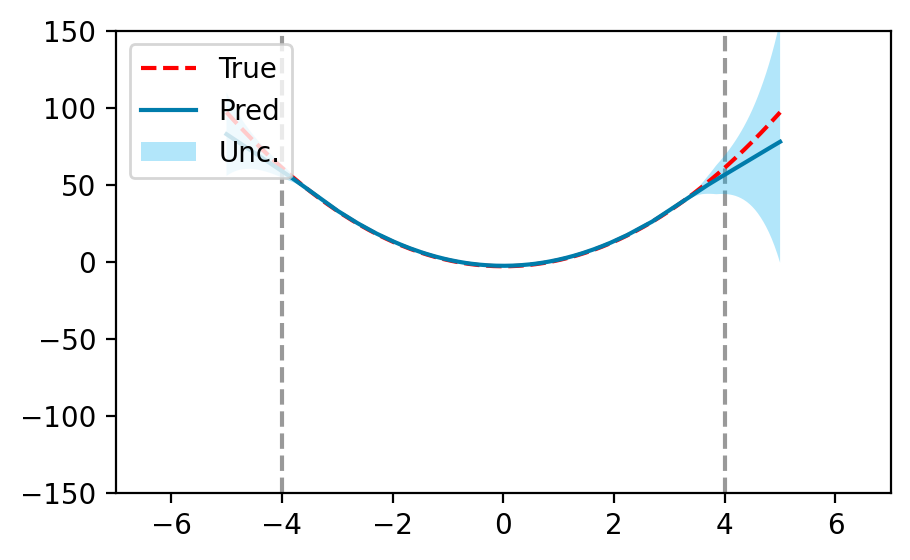

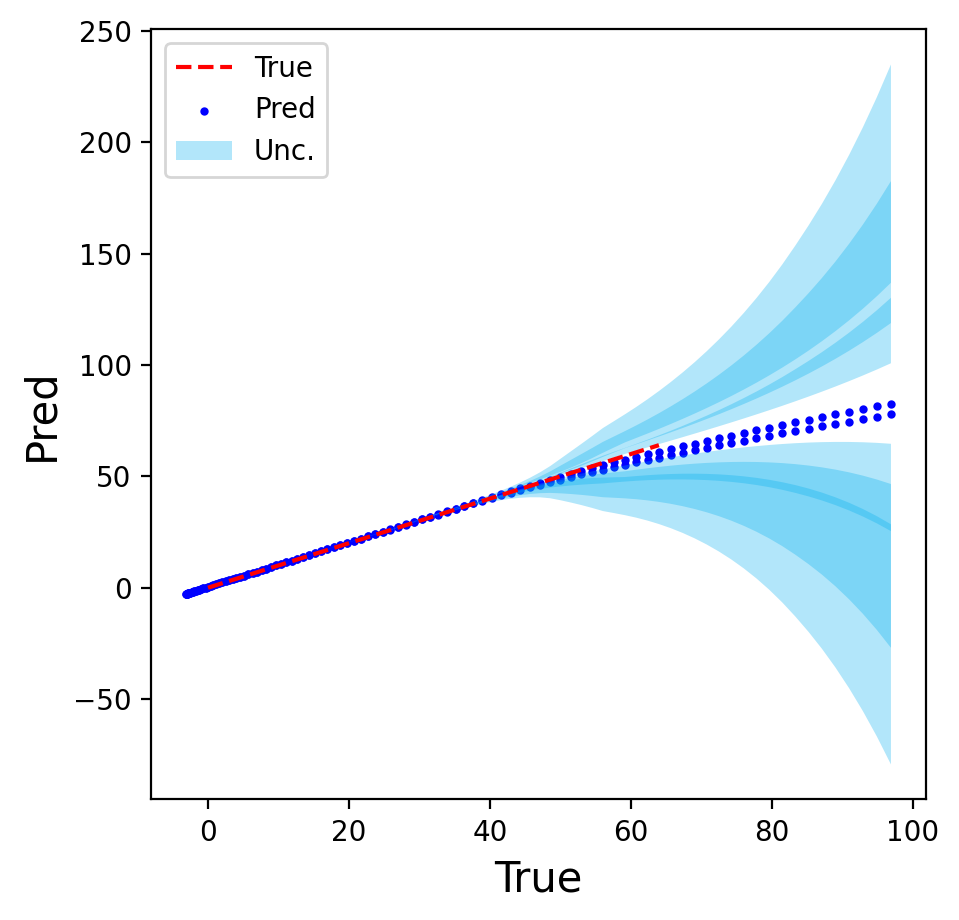

In [63]:
# Predict and plot using the trained model
y_pred = model(x_test)
#plot_predictions(x_train, y_train, x_test, y_test, y_pred)

print(x_test.shape)
plot_Alfonso(x_test, y_test, y_pred)

plot_PredvsTrue(y_test, y_pred)